# Adversarial Robustness Analysis

In [1]:
# Paths
LAINET_PATH = '/local-scratch/mrivas/dmasmont/misc/lnpfoo/lainet_trained.pth'#'/local-scratch/mrivas/dmasmont/misc/lnpfoo/lainet_adversarial.pth'
NEURALADM_PATH = '/local-scratch/mrivas/dmasmont/misc/lnpfoo/adv.pt'
device = 'cuda:4'
founders_vcf_file_path = '/local-scratch/mrivas/dmasmont/L3N/datasets/chr20_8anc_100/founders_train.vcf'
founders_map_file_path = '/local-scratch/mrivas/dmasmont/L3N/datasets/chr20_8anc_100/founders_train.map'
output_folder_prefix = '/local-scratch/mrivas/dmasmont/misc/lnpfoo/'

### Importing dependecies, loading dataset and networks

In [2]:
# Importing libraries
print('Start importing required libraries...')
import os, sys, time, allel, yaml, math, gzip, torch
sys.path.append('../LAI-Net/')
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from scipy.interpolate import interp1d
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import pickle as pkl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from lainet.utils.reader import load_founders_from_vcf_and_map

from helpers.method_inference import forward_haploid, forward_nadm, extend_if_lai
from helpers.adversarial_perturbation import cw_loss, subsample_adversarial_mask, eval_net_and_subsample, generate_adversarial_mask, run_robustness_analysis

print('Done importing, using pytorch version {}...'.format(torch.__version__))

Start importing required libraries...
Done importing, using pytorch version 1.12.1+cu102...


In [3]:
# Loading dataset
snps_all, labels_all, _, _, ancestry_names, _ = load_founders_from_vcf_and_map(founders_vcf_file_path, founders_map_file_path, make_haploid=True, random_split=False, verbose=True)

subset = 2
snps, labels = snps_all[0::subset,:], labels_all[0::subset]
print(snps.shape, labels.shape)

Loading vcf and .map files...
Done loading vcf and .map files...
A total of 3200 diploid individuals where found in the vcf and .map
A total of 8 ancestries where found: ['AFR' 'AHG' 'AMR' 'EAS' 'EUR' 'OCE' 'SAS' 'WAS']
(2880, 516800) (2880,)


In [4]:
# Loading LAI-Net
import lainet
print(f'Loading LAI-Net from {LAINET_PATH} ...')
LN = torch.load(LAINET_PATH, map_location=device)
LN.device = device
LN = LN.to(device)
LN = LN.eval()
print('Done loading LAI-Net')

Loading LAI-Net from /local-scratch/mrivas/dmasmont/misc/lnpfoo/lainet_trained.pth ...
Done loading LAI-Net


In [5]:
# Loading Neural ADMIXTURE
from neural_admixture.model.neural_admixture import NeuralAdmixture
print(f'Loading Neural ADMIXTURE from {NEURALADM_PATH} ...')
NADM= NeuralAdmixture([8], num_features=516800)
NADM.load_state_dict(torch.load(NEURALADM_PATH, map_location=device), strict=True)
NADM.device = device
NADM = NADM.to(device)
NADM = NADM.eval()
print('Done loading Neural ADMIXTURE')

Loading Neural ADMIXTURE from /local-scratch/mrivas/dmasmont/misc/lnpfoo/adv.pt ...
Done loading Neural ADMIXTURE


### Performing Adversarial Attacks

Running LAI-Net
 A total of NBATCH  45
0
0 mean  0.49993783235549927 loss  0.505903959274292 acc  0.125
1 mean  0.38661834597587585 loss  0.40231308341026306 acc  0.21875
2 mean  0.29167431592941284 loss  0.30538761615753174 acc  0.25
3 mean  0.22122810781002045 loss  0.2256808578968048 acc  0.0625
4 mean  0.16951189935207367 loss  0.16951189935207367 acc  0.078125
5 mean  0.13269364833831787 loss  0.13269364833831787 acc  0.328125
6 mean  0.10779517889022827 loss  0.10815051198005676 acc  0.359375
7 mean  0.09182196855545044 loss  0.0919402614235878 acc  0.359375
8 mean  0.08171028643846512 loss  0.0817231684923172 acc  0.34375
9 mean  0.07501493394374847 loss  0.07504065334796906 acc  0.328125
10 mean  0.07022881507873535 loss  0.07025238126516342 acc  0.328125
11 mean  0.06653586775064468 loss  0.06653586775064468 acc  0.3125
12 mean  0.06340669095516205 loss  0.06340669095516205 acc  0.3125
13 mean  0.06060072407126427 loss  0.06060072407126427 acc  0.3125
14 mean  0.05798371508717

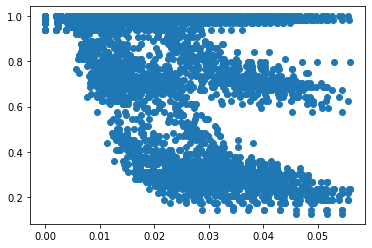

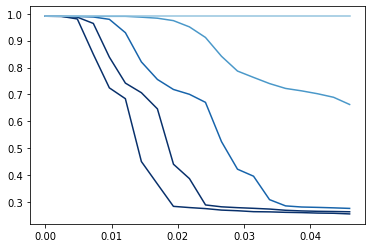

Done!
Running Neural-ADMIXTURE
 A total of NBATCH  45
0
0 mean  0.500019371509552 loss  0.558613121509552 acc  0.15625
1 mean  0.38184472918510437 loss  0.44043847918510437 acc  0.15625
2 mean  0.27391791343688965 loss  0.33251166343688965 acc  0.15625
3 mean  0.18384835124015808 loss  0.24244210124015808 acc  0.15625
4 mean  0.11518978327512741 loss  0.24746689200401306 acc  0.359375
5 mean  0.06955304741859436 loss  0.15424104034900665 acc  0.265625
6 mean  0.041927456855773926 loss  0.2823513150215149 acc  0.734375
7 mean  0.03047582507133484 loss  0.17144402861595154 acc  0.4375
8 mean  0.024744220077991486 loss  0.12930864095687866 acc  0.328125
9 mean  0.022076964378356934 loss  0.11749109625816345 acc  0.265625
10 mean  0.02101323753595352 loss  0.10805251449346542 acc  0.25
11 mean  0.020742066204547882 loss  0.10274414718151093 acc  0.21875
12 mean  0.020838091149926186 loss  0.10283952206373215 acc  0.21875
13 mean  0.021085768938064575 loss  0.10308704525232315 acc  0.21875


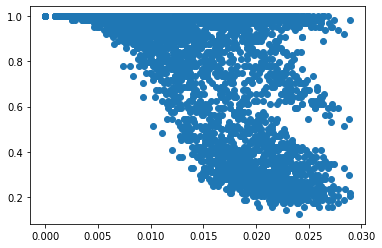

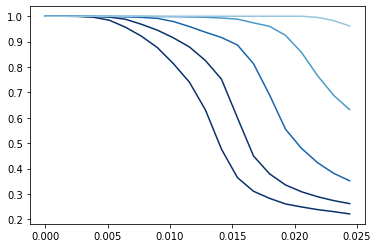

Done!


In [6]:

method_dict_lainet = {
    'name' : 'LAI-Net',
    'model' : LN,
    'forward' : forward_haploid,
    'lambda' : 1.0,
    'lr' : 0.05,
    'n_adv_steps' : 20
}



method_dict_nadm = {
    'name' : 'Neural-ADMIXTURE',
    'model' : NADM,
    'forward' : forward_nadm,
    'lambda' : 3.0,
    'lr' : 0.05,
    'n_adv_steps' : 20
}



store_dataset=True

for method_dict in [method_dict_lainet, method_dict_nadm]:
    
    # Performing Robustness Analysis
    name=method_dict['name']
    print(f'Running {name}')
    acc_array, adv_per_array, real_seqs, fake_seqs = run_robustness_analysis(snps, labels, method_dict, bsize=64, store_dataset=store_dataset, device=device)

    # Making scatter plot
    plt.scatter(adv_per_array, acc_array)
    plt.show()

    # Making line plot
    adv_per_array_m = np.mean(adv_per_array, axis=0)
    acc_array_m = np.mean(acc_array, axis=0)
    MAX_CMAP = adv_per_array_m.shape[0]+1
    cmap = cm.get_cmap('Blues', MAX_CMAP)
    for j in range(5):
        plt.plot(adv_per_array_m[j,:], acc_array_m[j,:], color=cmap(MAX_CMAP-j))
    plt.show()
    
    
    # Storing accuracy vs ratio results
    dict_to_save = {
    'name' : method_dict['name'],
    'per' : adv_per_array,
    'acc' : acc_array
    }

    with open(output_folder_prefix+f'per_acc_{name}.pkl', 'wb') as handle:
        pkl.dump(dict_to_save, handle, protocol=pkl.HIGHEST_PROTOCOL)

    # Save manipulated dataset
    if len(real_seqs) > 1:
        dict_to_save = {
        'name' : method_dict['name'],
        'real_seqs' : real_seqs,
        'fake_seqs' : fake_seqs
        }

        with open(output_folder_prefix+f'dataset_{name}.pkl', 'wb') as handle:
            pkl.dump(dict_to_save, handle, protocol=pkl.HIGHEST_PROTOCOL)
            
    print('Done!')

In [7]:
with open(output_folder_prefix+'per_acc_LAI-Net.pkl', 'rb') as handle:
    dict_lainet = pkl.load(handle)


adv_per_array = dict_lainet['per']
acc_array = dict_lainet['acc']

adv_per_array_m_lainet = np.mean(adv_per_array, axis=0)
acc_array_m_lainet = np.mean(acc_array, axis=0)

with open(output_folder_prefix+'per_acc_Neural-ADMIXTURE.pkl', 'rb') as handle:
    dict_lainet = pkl.load(handle)


adv_per_array = dict_lainet['per']
acc_array = dict_lainet['acc']

adv_per_array_m_nadm = np.mean(adv_per_array, axis=0)
acc_array_m_nadm = np.mean(acc_array, axis=0)

### Making Final Plot

<ipython-input-48-710791b83906>:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


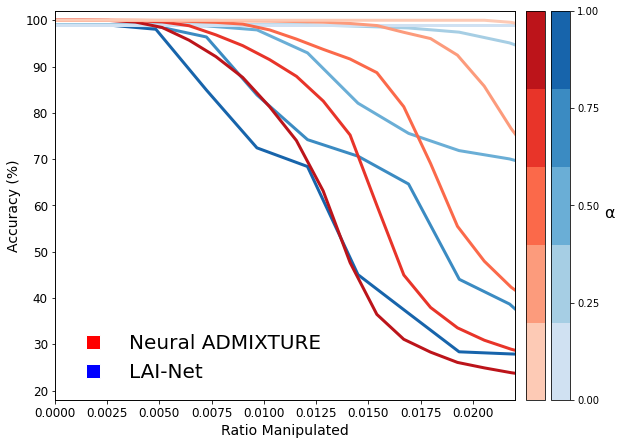

In [48]:
fig = plt.figure(figsize=(9,6))
fig.tight_layout() 
ax1 = fig.add_axes([0,0,0.9,0.9])

linewidth=3

MAX_CMAP = adv_per_array_m.shape[0]
cmap1 = cm.get_cmap('Blues', 256)
cmap1 = ListedColormap(cmap1(np.linspace(0.2, 0.8, MAX_CMAP)))

for j in range(5):
    ax1.plot(adv_per_array_m_lainet[j,:], acc_array_m_lainet[j,:]*100, color=cmap1(MAX_CMAP-j-1 ), linewidth=linewidth)
    
cmap2 = cm.get_cmap('Reds', 256)
cmap2 = ListedColormap(cmap2(np.linspace(0.2, 0.8, MAX_CMAP)))

for j in range(5):
    ax1.plot(adv_per_array_m_nadm[j,:], acc_array_m_nadm[j,:]*100, color=cmap2(MAX_CMAP-j-1), linewidth=linewidth)
    
norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ticks=np.linspace(0,1,MAX_CMAP), pad=-0.1)

norm = mpl.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm, ticks=np.linspace(0,1,MAX_CMAP), pad=0.02)

cb.ax.tick_params(size=0)
cb.set_ticks([])

ax1.set_xlim([0.0,0.022])
ax1.set_ylim([18.0,102.0])
fsize_label_axis = 14
ax1.set_xlabel('Ratio Manipulated', fontsize=fsize_label_axis)
ax1.set_ylabel('Accuracy (%)', fontsize=fsize_label_axis)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2 = ax1.twinx()
ax2.set_yticks([])
ax2.set_ylabel('α', fontsize=fsize_label_axis+2, labelpad=95, rotation=0)




markersize = 14
legend_elements = [
                    Line2D([0], [0], marker='s', color='w', label='Neural ADMIXTURE',markerfacecolor='red', markersize=markersize),
                    Line2D([0], [0], marker='s', color='w', label='LAI-Net',markerfacecolor='blue', markersize=markersize),
]


ax1.legend(handles=legend_elements, loc='lower left', fontsize=20, frameon=False)



plt.tight_layout()
plt.savefig('figs/manipulation_acc.png', bbox_inches = "tight")
plt.show()